In [1]:
import pandas as pd, numpy as np, seaborn as sns
from pprint import pprint
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import math
from collections import Counter

import datetime, time

from pprint import pprint
import re

In [2]:
def printRuntime():
    print(datetime.datetime.now().strftime("%Y-%m-%d %T"))
    print("-"*19)
printRuntime()

2020-03-02 23:12:59
-------------------


# 1. Load data

In [3]:
basePath = "./kalapa/"
trainPath = basePath + "train.csv"
testPath = basePath + "test.csv"
colDesc = basePath + "column_description.csv"
sampleSubmit = basePath + "sample_submission.csv"

cleanedTrain = basePath + "cleanedTrain.pickle"
cleanedTest = basePath + "cleanedTest.pickle"
nb01 = basePath + "nb01.pickle"
nb02 = basePath + "nb02.pickle"
nb03 = basePath + "nb03.pickle"
printRuntime()

2020-03-02 23:12:59
-------------------


In [4]:
def avgAge(row):
    a = row["age_source1"]
    b = row["age_source2"]
    if np.isnan(a) and np.isnan(b):
        return np.nan
    elif np.isnan(a):
        return b
    elif np.isnan(b):
        return a
    else:
        return (a+b)/2.0
    
def diffAge(row):
    a = row["age_source1"]
    b = row["age_source2"]
    if np.isnan(a) and np.isnan(b):
        return np.nan
    elif np.isnan(a):
        return -b
    elif np.isnan(b):
        return a
    else:
        return (a+b)/2.0
    
def groupAge(age):
    # Based on distribution of bad label and bad ratio
    # 18-21; 21-30; 30-45; 45+
    result = ""
    if np.isnan(age):
        result = "AGE_NONE"
    elif age <= 18:
        result = "AGE_0"
    elif age <= 21:
        result = "AGE_1"
    elif age <= 30:
        result = "AGE_2"
    elif age <= 45:
        result = "AGE_3"
    else:
        result = "AGE_4"
    return result
printRuntime()

2020-03-02 23:12:59
-------------------


# Train

In [5]:
pdfTrainRaw = pd.read_csv(trainPath)
printRuntime()

2020-03-02 23:13:01
-------------------


/Users/newuser/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
cond = (
    ~((pdfTrainRaw["age_source1"]<18) | (pdfTrainRaw["age_source2"]<18)) # Filter out age < 18, keep NaN
)
# pdfTrain = pdfTrainRaw[cond].copy()
pdfTrain = pdfTrainRaw.copy()
pdfTrain["maCv"] = pdfTrain["maCv"].apply(lambda x: str(x).lower())
pdfTrain["province"] = pdfTrain["province"].apply(lambda x: str(x).lower())
pdfTrain["district"] = pdfTrain["district"].apply(lambda x: str(x).lower())
print(pdfTrain.shape)
printRuntime()

(30000, 64)
2020-03-02 23:13:01
-------------------


In [7]:
lsMetaCol = ["id", "label", "province", "district", "age_source1", "age_source2", "maCv"]

# Test

In [8]:
pdfTestRaw = pd.read_csv(testPath)
printRuntime()

2020-03-02 23:13:02
-------------------


/Users/newuser/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
cond = (
    ~((pdfTestRaw["age_source1"]<18) | (pdfTestRaw["age_source2"]<18)) # Filter out age < 18, keep NaN
)
# pdfTest = pdfTestRaw[cond].copy()
pdfTest = pdfTestRaw.copy()
pdfTest["maCv"] = pdfTest["maCv"].apply(lambda x: str(x).lower())
pdfTest["province"] = pdfTest["province"].apply(lambda x: str(x).lower())
pdfTest["district"] = pdfTest["district"].apply(lambda x: str(x).lower())
print(pdfTest.shape)
printRuntime()

(20000, 63)
2020-03-02 23:13:03
-------------------


### Clean data

### Break down maCv to (maCv[:2] + maCv[2:])

In [10]:
def formatJob(iStr):
    if "none" == iStr or "nan" == iStr:
        return "none"
    # Replace all digit
    iStr = re.sub("\d", "", iStr)
    # Replace cn to cong nhan
    iStr = re.sub(r"^(cnhân|cn|coõng nhaõn)", "công nhân ", iStr)
    # Replace nv/nv. to nhan vien
    iStr = re.sub(r"(- nv|nv.|nv)", "nhân viên ", iStr)
    # Replace p. to phó
    iStr = re.sub(r"(^p\.)", "phó ", iStr)
    
    iStr = (iStr.replace("-", " ")
            .replace("cty", "công ty")
            .replace(".", " ")
            .replace("(", " ").
            replace(")", " ")
           )
    return iStr

def splitJobType(iStr):
    if "none" == iStr or "nan" == iStr:
        return "none", "none"
    iStr = formatJob(iStr)
    
    lsWord = iStr.split()
    if len(lsWord) == 0:
        return "none", "none"
    splitIdx = 2
    if "phó chánh" in iStr or ("phó trưởng" in iStr 
                               and "phó trưởng phòng" not in iStr
                               and "phó trưởng ban" not in iStr):
        splitIdx = 4
    elif ("phó phòng" not in iStr) and (lsWord[0] == "phó" or lsWord[0] == "trưởng"):
        splitIdx = 3
    
    jobCat = " ".join(lsWord[:splitIdx])
    jobDesc = "none"
    if len(lsWord) > splitIdx:
        jobDesc = " ".join(lsWord[splitIdx:])
    return jobCat, jobDesc

# Test
print(splitJobType("nhân viên phòng thí nghiệm"))
print(splitJobType("nhân viên bảo trì"))
print(splitJobType("cn ủi"))
print(splitJobType("9782cấp dưỡng"))
print(splitJobType("trưởng dây chuyền phòng sản xuất"))
print(splitJobType("p. trưởng phòng"))
printRuntime()

('nhân viên', 'phòng thí nghiệm')
('nhân viên', 'bảo trì')
('công nhân', 'ủi')
('cấp dưỡng', 'none')
('trưởng dây chuyền', 'phòng sản xuất')
('phó trưởng phòng', 'none')
2020-03-02 23:13:06
-------------------


In [11]:
# pdfTrain["jobCat"], pdfTrain["jobDesc"] = pdfTrain["maCv"].apply(lambda x: splitJobType(x))
%time
pdfTrain["maCv"] = pdfTrain["maCv"].apply(formatJob)
pdfTrain["maCv_vector"] = pdfTrain["maCv"].apply(lambda x: x.split())
pdfTrain["jobCat"], pdfTrain["jobDesc"] = zip(*pdfTrain["maCv"].apply(splitJobType))
printRuntime()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
2020-03-02 23:13:06
-------------------


In [12]:
# pdfTest["jobCat"], pdfTest["jobDesc"] = pdfTest["maCv"].apply(lambda x: splitJobType(x))
%time
pdfTest["maCv"] = pdfTest["maCv"].apply(formatJob)
pdfTest["maCv_vector"] = pdfTest["maCv"].apply(lambda x: x.split())
pdfTest["jobCat"], pdfTest["jobDesc"] = zip(*pdfTest["maCv"].apply(splitJobType))
printRuntime()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
2020-03-02 23:13:07
-------------------


In [13]:
pdfTrain = (pdfTrain
      .replace(np.nan, "None") # 'None' -> nan
      .replace("TRUE", True) # 'TRUE' -> True
      .replace("FALSE", False) # 'FALSE' -> False
     )

In [14]:
pdfTest = (pdfTest
      .replace(np.nan, "None") # 'None' -> nan
      .replace("TRUE", True) # 'TRUE' -> True
      .replace("FALSE", False) # 'FALSE' -> False
     )

In [15]:
pdfTrainBk = pdfTrain.copy()

pdfTestBk = pdfTest.copy()

#### Replace ilformed values by columns to safely remove

In [16]:
for dfTmp in [pdfTrain, pdfTest]:
    # 6
    dfTmp.loc[dfTmp["FIELD_6"]=="None", "FIELD_6"] = np.nan
    # dfTmp["FIELD_6"] = dfTmp["FIELD_6"] + 1
    
    # 12
    dfTmp.loc[~dfTmp["FIELD_12"].isin(["None", "0", "1"]), "FIELD_12"] = "None"

    # 35 'Four' 'One' 'Three' 'Two'
    dfTmp.loc[dfTmp["FIELD_35"]=="Zero", "FIELD_35"] = 1
    dfTmp.loc[dfTmp["FIELD_35"]=="One", "FIELD_35"] = 2
    dfTmp.loc[dfTmp["FIELD_35"]=="Two", "FIELD_35"] = 3
    dfTmp.loc[dfTmp["FIELD_35"]=="Three", "FIELD_35"] = 4
    dfTmp.loc[dfTmp["FIELD_35"]=="Four", "FIELD_35"] = 5
    
    # 40 
    dfTmp.loc[dfTmp["FIELD_40"].isin(["02 05 08 11", "05 08 11 02", "08 02"]), "FIELD_40"] = "02_05_08_11"
    
    # 41 I II III IV V
    dfTmp.loc[dfTmp["FIELD_41"]=="I", "FIELD_41"] = 1
    dfTmp.loc[dfTmp["FIELD_41"]=="II", "FIELD_41"] = 2
    dfTmp.loc[dfTmp["FIELD_41"]=="III", "FIELD_41"] = 3
    dfTmp.loc[dfTmp["FIELD_41"]=="IV", "FIELD_41"] = 4
    dfTmp.loc[dfTmp["FIELD_41"]=="V", "FIELD_41"] = 5

    # 42
    dfTmp.loc[dfTmp["FIELD_42"]=="Zezo", "FIELD_42"] = 0
    dfTmp.loc[dfTmp["FIELD_42"]=="One", "FIELD_42"] = 1

    # 44
    dfTmp.loc[dfTmp["FIELD_44"]=="One", "FIELD_44"] = 1
    dfTmp.loc[dfTmp["FIELD_44"]=="Two", "FIELD_44"] = 2

    # 45
    dfTmp.loc[(dfTmp["FIELD_45"]=="1")|(dfTmp["FIELD_45"]==1.0), "FIELD_45"] = 1
    dfTmp.loc[(dfTmp["FIELD_45"]=="2")|(dfTmp["FIELD_45"]==2.0), "FIELD_45"] = 2

### One-hot 8 (gender), 10, 12, 17, 24, 40, 43

In [17]:
pdfTrainBk1 = pdfTrain.copy()
pdfTestBk1 = pdfTest.copy()

In [18]:
lsCol = [8, 10, 12, 17, 24, 40, 43]

In [19]:
# Get one hot encoding of columns for pdfTrain pdfTest
for d in lsCol:
    cName = "FIELD_%d" % d
    print(cName)
    one_hot = pd.get_dummies(pdfTrain[cName].replace(np.nan, "None"))
    renameCol = {}
    for c in one_hot.columns:
        renameCol[c] = "%s_%s" % (cName, c)
    # pprint(renameCol)
    one_hot = one_hot.rename(columns=renameCol)
#     pdfTrain = pdfTrain.drop(cName, axis = 1)
    # Join the encoded pdfTrain
    pdfTrain = pdfTrain.join(one_hot)

FIELD_8
FIELD_10
FIELD_12
FIELD_17
FIELD_24
FIELD_40
FIELD_43


In [20]:
for d in lsCol:
    cName = "FIELD_%d" % d
    print(cName)
    one_hot = pd.get_dummies(pdfTest[cName].replace(np.nan, "None"))
    renameCol = {}
    for c in one_hot.columns:
        renameCol[c] = "%s_%s" % (cName, c)
    # pprint(renameCol)
    one_hot = one_hot.rename(columns=renameCol)
#     pdfTest = pdfTest.drop(cName, axis = 1)
    # Join the encoded pdfTest
    pdfTest = pdfTest.join(one_hot)

FIELD_8
FIELD_10
FIELD_12
FIELD_17
FIELD_24
FIELD_40
FIELD_43


In [21]:
for d in lsCol:
    cName = "FIELD_%d" % d
    lsMissCol = [c for c in pdfTrain.columns if cName in c and c not in pdfTest.columns]
    for c in lsMissCol:
        print(cName)
        print("Add missing columns for test")        
        print(c)
        pdfTest[c] = 0

    lsRedCol = [c for c in pdfTest.columns if cName in c and c not in pdfTrain.columns]
    for c in lsRedCol:
        print("Remove redundant columns for test")
        print(c)
        pdfTest = pdfTest.drop(c, axis=1)

FIELD_17
Add missing columns for test
FIELD_17_G2
FIELD_40
Add missing columns for test
FIELD_40_4


In [ ]:
print(pdfTrain.columns)

In [ ]:
"FIELD_43" in pdfTrain.columns

In [ ]:
"FIELD_43" in pdfTest.columns

### Add FIELD_7_MOST, FIELD_7_LEN, FIELD_9_APPEAR, FIELD_9_INDEX

In [22]:
def mostFrequent(List): 
    occurenceCount = Counter(List) 
    lsCount = occurenceCount.most_common()
    maxAppear = lsCount[0][1]
    # print(lsCount)
    # print(maxAppear)
    lsVal = [v[0] for v in lsCount if v[1] == maxAppear]
    # Return list of most common items (if equally appeared)
    return lsVal

def mostAppear(iStr):
    if iStr == "[]" or iStr is np.nan:
        return "na"
    lsChar = iStr.replace("'", "").replace("[", "").replace("]", "").replace(" ", "").split(",")
    return mostFrequent(lsChar)

# Test
print(mostFrequent([2, 2, 3, 3, 3, 4, 5, 6])) # Expect [3]
print(mostAppear("['GD', 'GD', 'TE']")) # Expect ["GD"]

def index_7_9(row):
    """
    Return: (is_appear, index)
    """
    lsMostAppear7 = row["FIELD_7_MOST"]
    val9 = row["FIELD_9"]
    if val9 == "[]" or val9 == "na":
        return -2, -1
    elif lsMostAppear7 == "na":
        return -1, -1
    elif val9 in lsMostAppear7:
        return 1, lsMostAppear7.index(val9)
    else:
        # lsMostAppear7 is not null but 9 doesn't appear
        return 0, -1
    
printRuntime()

[3]
['GD']
2020-03-02 23:13:33
-------------------


In [23]:
# Add col as most appear FIELD_7
pdfTrain["FIELD_7_MOST"] = pdfTrain["FIELD_7"].apply(lambda x: mostAppear(x))
pdfTrain["FIELD_7_LEN"] = pdfTrain["FIELD_7_MOST"].apply(len)
# Add col as 9 appear in 7_MOST
pdfTrain["FIELD_9_APPEAR"], pdfTrain["FIELD_9_INDEX"] = zip(*pdfTrain.apply(lambda row: index_7_9(row), axis=1))

In [24]:
# Add col as most appear FIELD_7
pdfTest["FIELD_7_MOST"] = pdfTest["FIELD_7"].apply(lambda x: mostAppear(x))
pdfTest["FIELD_7_LEN"] = pdfTest["FIELD_7_MOST"].apply(len)
# Add col as 9 appear in 7_MOST
pdfTest["FIELD_9_APPEAR"], pdfTest["FIELD_9_INDEX"] = zip(*pdfTest.apply(lambda row: index_7_9(row), axis=1))

In [25]:
pdfTrain = pdfTrain.drop("FIELD_7_MOST", axis = 1)

pdfTest = pdfTest.drop("FIELD_7_MOST", axis = 1)

### Add avg_age, diff_age, group_age

In [26]:
pdfTrain.loc[pdfTrain["age_source1"]=="None", "age_source1"] = np.nan
pdfTrain.loc[pdfTrain["age_source2"]=="None", "age_source2"] = np.nan

In [27]:
pdfTrain["FIELD_avg_age"] = pdfTrain.apply(lambda row: avgAge(row), axis=1)
pdfTrain["FIELD_diff_age"] = pdfTrain.apply(lambda row: diffAge(row), axis=1)
pdfTrain["group_age"] = pdfTrain["FIELD_avg_age"].apply(lambda x: groupAge(x))
printRuntime()

2020-03-02 23:13:40
-------------------


In [28]:
pdfTest.loc[pdfTest["age_source1"]=="None", "age_source1"] = np.nan
pdfTest.loc[pdfTest["age_source2"]=="None", "age_source2"] = np.nan

In [29]:
pdfTest["FIELD_avg_age"] = pdfTest.apply(lambda row: avgAge(row), axis=1)
pdfTest["FIELD_diff_age"] = pdfTest.apply(lambda row: diffAge(row), axis=1)
pdfTest["group_age"] = pdfTest["FIELD_avg_age"].apply(lambda x: groupAge(x))
printRuntime()

2020-03-02 23:13:42
-------------------


### One hot group_age

In [30]:
cName = "group_age"
one_hot = pd.get_dummies(pdfTrain[cName].replace(np.nan, "None"))
renameCol = {}
for c in one_hot.columns:
    renameCol[c] = "FIELD_%s" % (c)
pprint(renameCol)
one_hot = one_hot.rename(columns=renameCol)

# pdfTrain = pdfTrain.drop(cName, axis = 1)
# Join the encoded pdfTrain
pdfTrain = pdfTrain.join(one_hot)
printRuntime()

{'AGE_0': 'FIELD_AGE_0',
 'AGE_1': 'FIELD_AGE_1',
 'AGE_2': 'FIELD_AGE_2',
 'AGE_3': 'FIELD_AGE_3',
 'AGE_4': 'FIELD_AGE_4',
 'AGE_NONE': 'FIELD_AGE_NONE'}
2020-03-02 23:13:42
-------------------


In [31]:
cName = "group_age"
one_hot = pd.get_dummies(pdfTest[cName].replace(np.nan, "None"))
renameCol = {}
for c in one_hot.columns:
    renameCol[c] = "FIELD_%s" % (c)
pprint(renameCol)
one_hot = one_hot.rename(columns=renameCol)

# pdfTest = pdfTest.drop(cName, axis = 1)
# Join the encoded pdfTest
pdfTest = pdfTest.join(one_hot)
printRuntime()

{'AGE_0': 'FIELD_AGE_0',
 'AGE_1': 'FIELD_AGE_1',
 'AGE_2': 'FIELD_AGE_2',
 'AGE_3': 'FIELD_AGE_3',
 'AGE_4': 'FIELD_AGE_4',
 'AGE_NONE': 'FIELD_AGE_NONE'}
2020-03-02 23:13:42
-------------------


In [32]:
pdfTrainBk2 = pdfTrain.copy()

pdfTestBk2 = pdfTest.copy()

### Add lv3_loc

In [33]:
pdfTrain["lv3_loc"] = "[" + pdfTrain["province"] + "]_[" + pdfTrain["district"] + "]"
lsProvince = pdfTrain["province"].unique()
lsLoc = pdfTrain["lv3_loc"].unique()
print(len(lsProvince), len(lsLoc))
printRuntime()

65 766
2020-03-02 23:13:51
-------------------


In [34]:
pdfTest["lv3_loc"] = "[" + pdfTest["province"] + "]_[" + pdfTest["district"] + "]"
lsProvince = pdfTest["province"].unique()
lsLoc = pdfTest["lv3_loc"].unique()
print(len(lsProvince), len(lsLoc))
printRuntime()

65 724
2020-03-02 23:13:51
-------------------


### Convert data types

In [35]:
lsExtraFt = (["FIELD_7_LEN", "FIELD_9_APPEAR", "FIELD_9_INDEX"]  + ["avg_age", "diff_age"]
             )

In [36]:
lsFieldFt = ([c for c in pdfTrain.columns 
              if "FIELD" in c 
              and c not in ["FIELD_%d"%d for d in [7, 9, 13, 39]]] 
#              + lsExtraFt
            )
# pprint(lsFieldFt)
printRuntime()

2020-03-02 23:13:57
-------------------


In [37]:
lsFieldFtTest = ([c for c in pdfTest.columns 
                  if "FIELD" in c 
                  and c not in ["FIELD_%d"%d for d in [7, 9, 13, 39]]]
#                  + lsExtraFt
                )
print(sorted(lsFieldFtTest) == sorted(lsFieldFt))
printRuntime()

True
2020-03-02 23:13:58
-------------------


In [38]:
lsFieldFt

['FIELD_1',
 'FIELD_2',
 'FIELD_3',
 'FIELD_4',
 'FIELD_5',
 'FIELD_6',
 'FIELD_8',
 'FIELD_10',
 'FIELD_11',
 'FIELD_12',
 'FIELD_14',
 'FIELD_15',
 'FIELD_16',
 'FIELD_17',
 'FIELD_18',
 'FIELD_19',
 'FIELD_20',
 'FIELD_21',
 'FIELD_22',
 'FIELD_23',
 'FIELD_24',
 'FIELD_25',
 'FIELD_26',
 'FIELD_27',
 'FIELD_28',
 'FIELD_29',
 'FIELD_30',
 'FIELD_31',
 'FIELD_32',
 'FIELD_33',
 'FIELD_34',
 'FIELD_35',
 'FIELD_36',
 'FIELD_37',
 'FIELD_38',
 'FIELD_40',
 'FIELD_41',
 'FIELD_42',
 'FIELD_43',
 'FIELD_44',
 'FIELD_45',
 'FIELD_46',
 'FIELD_47',
 'FIELD_48',
 'FIELD_49',
 'FIELD_50',
 'FIELD_51',
 'FIELD_52',
 'FIELD_53',
 'FIELD_54',
 'FIELD_55',
 'FIELD_56',
 'FIELD_57',
 'FIELD_8_FEMALE',
 'FIELD_8_MALE',
 'FIELD_8_None',
 'FIELD_10_GH',
 'FIELD_10_None',
 'FIELD_10_T1',
 'FIELD_12_0',
 'FIELD_12_1',
 'FIELD_12_None',
 'FIELD_17_G2',
 'FIELD_17_G3',
 'FIELD_17_G4',
 'FIELD_17_G7',
 'FIELD_17_G8',
 'FIELD_17_G9',
 'FIELD_17_GX',
 'FIELD_17_None',
 'FIELD_24_K1',
 'FIELD_24_K2',
 'FIE

In [39]:
for c in lsFieldFt:
    try:
        pdfTrain.loc[pdfTrain[c].isin(["None", "na"]), c] = np.nan
        pdfTrain[c] = pdfTrain[c].astype(np.float64)
        pdfTest.loc[pdfTest[c].isin(["None", "na"]), c] = np.nan
        pdfTest[c] = pdfTest[c].astype(np.float64)
    except:
        print(c)
printRuntime()

FIELD_8
FIELD_10
FIELD_17
FIELD_24
FIELD_40
FIELD_43
2020-03-02 23:14:03
-------------------


In [40]:
# 2
lsCatCol = ["FIELD_%d"%d for d in [8, 10, 17, 24, 40, 43]]
lsNumCol = [c for c in lsFieldFt if c not in lsCatCol]

## Cluster test, use predicted cluster in train & test, add as 1-hot features

In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
#from sklearn.impute import SimpleImputer

In [42]:
pdfTrainFillna = pdfTrain.replace([np.inf, -np.inf], np.nan).fillna(0.0)
pdfTestFillna = pdfTest.replace([np.inf, -np.inf], np.nan).fillna(0.0)
printRuntime()

2020-03-02 23:14:07
-------------------


In [43]:
X = pdfTrainFillna[lsNumCol].values
Y = pdfTestFillna[lsNumCol].values
scaler = MinMaxScaler()
Y_scaled = scaler.fit_transform(Y)
X_scaled = scaler.transform(X) # Use scaler by Y
printRuntime()

2020-03-02 23:14:08
-------------------


In [44]:
ky_15 = KMeans(n_clusters=15).fit(Y_scaled)

In [45]:
X_cluster = ky_15.predict(X_scaled)

In [46]:
Y_cluster = ky_15.predict(Y_scaled)

In [47]:
X_cluster.shape, Y_cluster.shape

((30000,), (20000,))

In [48]:
pdfTrain["kmean_cluster"] = X_cluster
pdfTest["kmean_cluster"] = Y_cluster

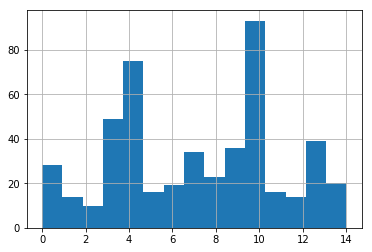

In [50]:
pdfTrain[pdfTrain["label"]==1]["kmean_cluster"].hist(bins=15)

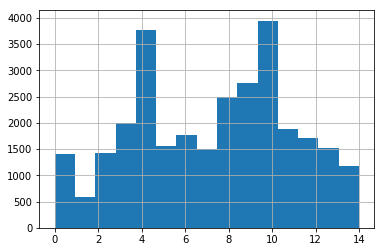

In [51]:
pdfTrain[pdfTrain["label"]==0]["kmean_cluster"].hist(bins=15)

In [ ]:
pdfB = (pdfTrain.groupby(["kmean_cluster", "jobCat"], as_index=False)
        .agg({"id": "count", "label":("sum", "mean")})
       )
pdfB.head(20)

In [ ]:
pdfA = (pdfTrain.groupby(["kmean_cluster", "label"], as_index=False).agg({"id": "count"})
        .pivot(index="kmean_cluster", columns="label", values="id").rename_axis(None)
       )
pdfA["ratio"] = pdfA[1]/pdfA[0]
pdfA.sort_values(["ratio"])

In [ ]:
pdfTest["kmean_cluster"].hist()

In [52]:
# 1 hot kmean_cluster columns
cName = "kmean_cluster"
# -- Train -- #
one_hot = pd.get_dummies(pdfTrain[cName].replace(np.nan, "None"))
renameCol = {}
for c in one_hot.columns:
    renameCol[c] = "FIELD_KMeans_%s" % (c)
pprint(renameCol)
one_hot = one_hot.rename(columns=renameCol)
pdfTrain = pdfTrain.join(one_hot)

# -- Test -- #
one_hot = pd.get_dummies(pdfTest[cName].replace(np.nan, "None"))
renameCol = {}
for c in one_hot.columns:
    renameCol[c] = "FIELD_KMeans_%s" % (c)
# pprint(renameCol)
one_hot = one_hot.rename(columns=renameCol)
pdfTest = pdfTest.join(one_hot)

printRuntime()

{0: 'FIELD_KMeans_0',
 1: 'FIELD_KMeans_1',
 2: 'FIELD_KMeans_2',
 3: 'FIELD_KMeans_3',
 4: 'FIELD_KMeans_4',
 5: 'FIELD_KMeans_5',
 6: 'FIELD_KMeans_6',
 7: 'FIELD_KMeans_7',
 8: 'FIELD_KMeans_8',
 9: 'FIELD_KMeans_9',
 10: 'FIELD_KMeans_10',
 11: 'FIELD_KMeans_11',
 12: 'FIELD_KMeans_12',
 13: 'FIELD_KMeans_13',
 14: 'FIELD_KMeans_14'}
2020-03-02 23:15:41
-------------------


In [53]:
lsKMeansFt = [c for c in pdfTrain.columns if "KMeans" in c]
for c in lsKMeansFt:
    print(pdfTrain[c].dtypes)

uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


### Add neighbor features
Neighbor features: 
    + avg+std of groupby (province, age_group, maCv)
    + avg+std of groupby (lv3_loc, age_group, maCv)
    + avg+std of groupby (province, maCv)
    

In [54]:
lsExtraFt = (["FIELD_7_LEN", "FIELD_9_APPEAR", "FIELD_9_INDEX"]  + ["avg_age", "diff_age"]
             )

In [55]:
lsFieldFt = ([c for c in pdfTrain.columns 
              if "FIELD" in c 
              and c not in ["FIELD_%d"%d for d in [7, 9, 13, 39]]] 
#              + lsExtraFt
            )
# pprint(lsFieldFt)
printRuntime()

2020-03-02 23:15:49
-------------------


In [56]:
lsFieldFtTest = ([c for c in pdfTest.columns 
                  if "FIELD" in c 
                  and c not in ["FIELD_%d"%d for d in [7, 9, 13, 39]]]
#                  + lsExtraFt
                )
print(sorted(lsFieldFtTest) == sorted(lsFieldFt))
printRuntime()

True
2020-03-02 23:15:52
-------------------


In [57]:
# 1
lsMetaCol1 = ["province", "group_age", "jobCat"]
lsMetaCol2 = ["province", "group_age"]
lsMetaCol3 = ["province", "jobCat"]
# 2
lsCatCol = ["FIELD_%d"%d for d in [8, 10, 17, 24, 40, 43]]
lsNumCol = [c for c in lsFieldFt if c not in lsCatCol]

In [59]:
len(lsNumCol) # 92 vs. 108

108

In [58]:
aggDict = {}
for f in lsNumCol:
    aggDict[f] = ["mean", "std"]

In [60]:
dfNb01 = pdfTrain[lsMetaCol1+lsNumCol].groupby(lsMetaCol1, as_index=False).agg(aggDict)
dfNb01.columns = ["_".join(x) for x in dfNb01.columns.ravel()]
dfNb01 = dfNb01.rename(columns={"province_": "province", 
                       "group_age_": "group_age", 
                       "jobCat_": "jobCat"})
printRuntime()

2020-03-02 23:16:43
-------------------


In [61]:
dfNb02 = pdfTrain[lsMetaCol2+lsNumCol].groupby(lsMetaCol2, as_index=False).agg(aggDict)
dfNb02.columns = ["_".join(x) for x in dfNb02.columns.ravel()]
dfNb02 = dfNb02.rename(columns={"province_": "province", 
                       "group_age_": "group_age", 
                       "jobCat_": "jobCat"})
printRuntime()

2020-03-02 23:16:44
-------------------


In [62]:
dfNb03 = pdfTrain[lsMetaCol3+lsNumCol].groupby(lsMetaCol3, as_index=False).agg(aggDict)
dfNb03.columns = ["_".join(x) for x in dfNb03.columns.ravel()]
dfNb03 = dfNb03.rename(columns={"province_": "province", 
                       "group_age_": "group_age", 
                       "jobCat_": "jobCat"})
printRuntime()

2020-03-02 23:16:45
-------------------


### raw ft + nb ft + standardize raw ft

In [63]:
lsMetaCol = ["id", "label", "province", "district", "lv3_loc", 
              "age_source1", "age_source2", "avg_age", "diff_age", "group_age",
              "maCv", "jobCat", "jobDesc"]
lsEmbedFt = ["FIELD_%d"%d for d in [7, 9, 13, 39]]
lsCol = [8, 10, 12, 17, 24, 40, 43] # For target encoding
lsCatCol = ["FIELD_%d"%d for d in lsCol] + ["group_age", "kmean_cluster"]
# raw ft
lsFieldFt = ([c for c in pdfTrain.columns 
             if "FIELD" in c 
             and c not in lsEmbedFt and c not in lsCatCol]
            )

label = "label"
printRuntime()

2020-03-02 23:17:01
-------------------


#### NB Ft1: province, group_age, jobCat

In [64]:
# nb ft
print("Merge nb01")
lsNbMetaCol = lsMetaCol1
dfNb = dfNb01 

dfITrain = pd.merge(pdfTrain, dfNb01, on=lsNbMetaCol, how="left")

print(dfITrain.shape)
printRuntime()

Merge nb01
(30000, 347)
2020-03-02 23:25:56
-------------------


In [65]:
for c in lsFieldFt:
    dfITrain["%s_stdized1"%c] = (dfITrain[c] - dfITrain[c+"_mean"])/dfITrain[c+"_std"]
print(dfITrain.shape) # (29924, 353)
printRuntime()

(30000, 454)
2020-03-02 23:25:57
-------------------


In [66]:
print("Drop nb01 group ft (mean, std)")
lsNb01Ft = [c for c in dfNb01.columns if "FIELD" in c]
print("%d columns"%len(lsNb01Ft))
dfITrain = dfITrain.drop(lsNb01Ft, axis=1)
print(dfITrain.shape)
printRuntime()

Drop nb01 group ft (mean, std)
216 columns
(30000, 238)
2020-03-02 23:25:58
-------------------


#### NB Ft2: province, group_age

In [67]:
# nb ft
lsNbMetaCol = lsMetaCol2
dfNb = dfNb02

print("Pre-merge shape:", dfITrain.shape)
dfITrain = pd.merge(dfITrain, dfNb, on=lsNbMetaCol, how="left")

print("Post-merge shape:", dfITrain.shape)
printRuntime()

Pre-merge shape: (30000, 238)
Post-merge shape: (30000, 454)
2020-03-02 23:26:39
-------------------


In [68]:
for c in lsFieldFt:
    dfITrain["%s_stdized2"%c] = (dfITrain[c] - dfITrain[c+"_mean"])/dfITrain[c+"_std"]
print(dfITrain.shape) # (29924, 252)
printRuntime()

(30000, 561)
2020-03-02 23:26:43
-------------------


In [69]:
print("Drop nb02 group ft (mean, std)")
lsNb02Ft = [c for c in dfNb02.columns if "FIELD" in c]
print("%d columns"%len(lsNb02Ft))
dfITrain = dfITrain.drop(lsNb02Ft, axis=1)
print(dfITrain.shape)
printRuntime()

Drop nb02 group ft (mean, std)
216 columns
(30000, 345)
2020-03-02 23:26:44
-------------------


#### NB Ft3: province, jobCat

In [70]:
# nb ft
lsNbMetaCol = lsMetaCol3
dfNb = dfNb03
printRuntime()

2020-03-02 23:26:50
-------------------


In [71]:
print("Pre-merge shape:", dfITrain.shape)
dfITrain = pd.merge(dfITrain, dfNb, on=lsNbMetaCol, how="left")

print("Post-merge shape:", dfITrain.shape)
printRuntime()

Pre-merge shape: (30000, 345)
Post-merge shape: (30000, 561)
2020-03-02 23:26:52
-------------------


In [72]:
for c in lsFieldFt:
    dfITrain["%s_stdized3"%c] = (dfITrain[c] - dfITrain[c+"_mean"])/dfITrain[c+"_std"]
print(dfITrain.shape) # (29924, 353)
printRuntime()

(30000, 668)
2020-03-02 23:26:56
-------------------


In [73]:
print("Drop nb03 group ft (mean, std)")
lsNb03Ft = [c for c in dfNb03.columns if "FIELD" in c]
print("%d columns"%len(lsNb03Ft))
dfITrain = dfITrain.drop(lsNb03Ft, axis=1)
print(dfITrain.shape)
printRuntime()

Drop nb03 group ft (mean, std)
216 columns
(30000, 452)
2020-03-02 23:26:57
-------------------


### Save iTrain data

In [74]:
ymd = datetime.datetime.now().strftime("%Y%m%d")
iTrainPath = basePath + "itrain_{}.pickle".format(ymd)
print(iTrainPath)
dfITrain.to_pickle(iTrainPath, compression="bz2")
printRuntime()

./kalapa/itrain_20200302.pickle
2020-03-02 23:28:12
-------------------


In [ ]:
dfITrain.head()

# Prepare itest

In [75]:
print("Merge test nb01")
lsNbMetaCol = lsMetaCol1
dfNb = dfNb01
dfITest = pd.merge(pdfTest, dfNb, on=lsNbMetaCol, how="left")

dfITest.shape # label col is missing

lsTmp = [c for c in dfITest.columns if c not in lsFieldFt]
# pprint(lsTmp)

Merge test nb01


In [76]:
for c in lsFieldFt:
    # stdized1, stdized2 and stdized3
    dfITest["%s_stdized1"%c] = (dfITest[c] - dfITest[c+"_mean"])/dfITest[c+"_std"]
print(dfITest.shape) # (19936, 340)
printRuntime()

(20000, 453)
2020-03-02 23:28:34
-------------------


In [77]:
print("Drop nb01 group ft (mean, std)")
lsNb01Ft = [c for c in dfNb01.columns if "FIELD" in c]
dfITest = dfITest.drop(lsNb01Ft, axis=1)
print(dfITest.shape)
printRuntime()

Drop nb01 group ft (mean, std)
(20000, 237)
2020-03-02 23:28:35
-------------------


#### NB Ft2: province, group_age

In [78]:
# nb ft
lsNbMetaCol = lsMetaCol2
dfNb = dfNb02

print("Pre-merge shape:", dfITest.shape)
dfITest = pd.merge(dfITest, dfNb, on=lsNbMetaCol, how="left")

print("Post-merge shape:", dfITest.shape)
printRuntime()

Pre-merge shape: (20000, 237)
Post-merge shape: (20000, 453)
2020-03-02 23:28:44
-------------------


In [79]:
for c in lsFieldFt:
    dfITest["%s_stdized2"%c] = (dfITest[c] - dfITest[c+"_mean"])/dfITest[c+"_std"]
print(dfITest.shape) # (29924, 252)
printRuntime()

(20000, 560)
2020-03-02 23:28:48
-------------------


In [80]:
print("Drop nb02 group ft (mean, std)")
lsNb02Ft = [c for c in dfNb02.columns if "FIELD" in c]
print("%d columns"%len(lsNb02Ft))
dfITest = dfITest.drop(lsNb02Ft, axis=1)
print(dfITest.shape)
printRuntime()

Drop nb02 group ft (mean, std)
216 columns
(20000, 344)
2020-03-02 23:28:53
-------------------


#### NB Ft3: province, group_age, jobCat

In [81]:
# nb ft
print("Merge nb03")
lsNbMetaCol = lsMetaCol3
dfNb = dfNb03

print("Pre-merge shape:", dfITest.shape)
dfITest = pd.merge(dfITest, dfNb, on=lsNbMetaCol, how="left")

print("Post-merge shape:", dfITest.shape)
printRuntime()

Merge nb03
Pre-merge shape: (20000, 344)
Post-merge shape: (20000, 560)
2020-03-02 23:28:58
-------------------


In [82]:
for c in lsFieldFt:
    dfITest["%s_stdized3"%c] = (dfITest[c] - dfITest[c+"_mean"])/dfITest[c+"_std"]
print(dfITest.shape) # (29924, 353)
printRuntime()

(20000, 667)
2020-03-02 23:29:05
-------------------


In [83]:
print("Drop nb03 group ft (mean, std)")
lsNb03Ft = [c for c in dfNb03.columns if "FIELD" in c]
dfITest = dfITest.drop(lsNb03Ft, axis=1)
print(dfITest.shape)
printRuntime()

Drop nb03 group ft (mean, std)
(20000, 451)
2020-03-02 23:29:06
-------------------


### Save iTest data

In [84]:
dfITrain.shape, dfITest.shape

((30000, 452), (20000, 451))

In [85]:
iTestPath = basePath + "itest_{}.pickle".format(ymd)
dfITest.to_pickle(iTestPath, compression="bz2")
printRuntime()

2020-03-02 23:29:22
-------------------
